In [1]:
import torch
from d2l import torch as d2l
import numpy as np

torch.set_printoptions(2)  # 精简输出精度

In [2]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))

561 728


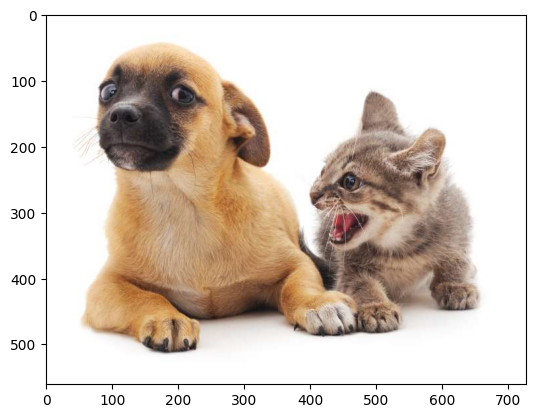

In [3]:
d2l.plt.imshow(img);

In [4]:
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框
    :param data: shape=(batch_size, channel, height, width)
    """
    in_height, in_width = data.shape[-2:]  # 561, 728 
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor  = torch.tensor(sizes,  device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width   # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width,  device=device) + offset_w) * steps_w
    # print(center_h)
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # print(size_tensor)
    # print(ratio_tensor)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    # me: wa_ratio = hs*sqrt(r)/w, ha_ratio = s/sqrt(r)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                    sizes[0] * torch.sqrt(ratio_tensor[1:])) )\
                   * in_height / in_width  # 处理矩形输入
    
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                      sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 除以2来获得半高和半宽
    # 在第0维重复in_height * in_width次，在第1维重复1次
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2 
    
    print(torch.stack((-w, -h, w, h)).T )

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    print(shift_x)

    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    
    print(out_grid.shape, anchor_manipulations.shape)
    output = out_grid + anchor_manipulations
    # me: output: (wa_ratio_min, ha_ratio_min, wa_ratio_max, ha_ratio_max), 
    # me：其中wa_ratio_max-wa_ratio_min=wa_ratio, ha_ratio_max-ha_ratio_min=ha_ratio
    return output.unsqueeze(0)

In [5]:
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]) 
Y.shape

tensor([[-0.58, -0.75,  0.58,  0.75],
        [-0.39, -0.50,  0.39,  0.50],
        [-0.19, -0.25,  0.19,  0.25],
        [-0.82, -0.53,  0.82,  0.53],
        [-0.41, -1.06,  0.41,  1.06]])
tensor([6.87e-04, 2.06e-03, 3.43e-03,  ..., 9.97e-01, 9.98e-01, 9.99e-01])
torch.Size([2042040, 4]) torch.Size([2042040, 4])


torch.Size([1, 2042040, 4])

In [6]:
Y

tensor([[[-0.29, -0.37,  0.29,  0.38],
         [-0.19, -0.25,  0.19,  0.25],
         [-0.10, -0.12,  0.10,  0.13],
         ...,
         [ 0.90,  0.87,  1.10,  1.12],
         [ 0.59,  0.73,  1.41,  1.26],
         [ 0.79,  0.47,  1.20,  1.53]]])

In [7]:
boxes = Y.reshape(h, w, 5, 4)

In [8]:
boxes[280, 364, :, :]

tensor([[ 0.21,  0.12,  0.79,  0.88],
        [ 0.31,  0.25,  0.69,  0.75],
        [ 0.40,  0.38,  0.60,  0.62],
        [ 0.09,  0.23,  0.91,  0.77],
        [ 0.30, -0.03,  0.71,  1.03]])

In [9]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

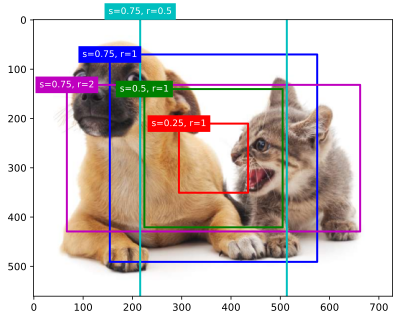

In [10]:
d2l.set_figsize(figsize=(7, 5))
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[280, 364, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])
# me: (wa_ratio_min, ha_ratio_min, wa_ratio_max, ha_ratio_max)*(w, h, w, h) = (wa_min, ha_min, wa_max, ha_max)
# me: 其中 wa_max-wa_min=wa=hs*sqrt(r), ha_max-ha_min=ha=hs/sqrt(r)
# me: 所以 锚框的面积为原来的 wa*ha/wh = h^2s^2/wh = s^2h/w倍

In [11]:
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts, inter_lowerrights,inters的形状: (boxes1的数量,boxes2的数量,2)
    inter_upperlefts  = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # me: 重合矩形左上角坐标。 torch.max通过广播做笛卡尔积
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # me: 重合矩形右下角坐标。 torch.min通过广播做笛卡尔积
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0) # me：clamp方法将tensor中小于min的元素赋值为min
    
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas # me：areas1[:, None] + areas2做笛卡尔积
    
    return inter_areas / union_areas

In [12]:
num_boxes1 = 3
num_boxes2 = 5

x_left_boxes1  = torch.tensor(np.random.uniform(low=0.5,  high=10.5, size=num_boxes1))[:,None]
x_right_boxes1 = torch.tensor(np.random.uniform(low=10.6, high=20.5, size=num_boxes1))[:,None]
y_lower_boxes1 = torch.tensor(np.random.uniform(low=3.5,  high=13.5, size=num_boxes1))[:,None]
y_upper_boxes1 = torch.tensor(np.random.uniform(low=13.5,  high=23.5, size=num_boxes1))[:,None]

x_left_boxes2  = torch.tensor(np.random.uniform(low=5.5,   high=10.5, size=num_boxes2))[:,None]
x_right_boxes2 = torch.tensor(np.random.uniform(low=15.6,  high=25.5, size=num_boxes2))[:,None]
y_lower_boxes2 = torch.tensor(np.random.uniform(low=5.5,   high=15.5, size=num_boxes2))[:,None]
y_upper_boxes2 = torch.tensor(np.random.uniform(low=15.6,  high=25.5, size=num_boxes2))[:,None]

boxes1 = torch.concat((x_left_boxes1, y_lower_boxes1, x_right_boxes1, y_upper_boxes1), dim=-1)
boxes2 = torch.concat((x_left_boxes2, y_lower_boxes2, x_right_boxes2, y_upper_boxes2), dim=-1)

In [13]:
print(boxes1)
print()
print(boxes2)

tensor([[ 4.37, 12.13, 14.05, 14.43],
        [ 4.61, 12.65, 18.67, 17.10],
        [ 7.85,  7.98, 20.44, 18.98]], dtype=torch.float64)

tensor([[ 8.34, 14.89, 21.29, 21.07],
        [ 6.97,  7.62, 16.80, 23.56],
        [ 6.03, 15.32, 16.55, 18.86],
        [ 8.63,  9.22, 19.58, 23.86],
        [10.39,  5.76, 20.84, 15.85]], dtype=torch.float64)


In [14]:
box_iou(boxes2, boxes1)

tensor([[0.00, 0.19, 0.29],
        [0.10, 0.25, 0.50],
        [0.00, 0.23, 0.21],
        [0.07, 0.25, 0.56],
        [0.07, 0.19, 0.48]], dtype=torch.float64)

In [15]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """
    将最接近的真实边界框分配给锚框
    me：本函数的一个缺点，先前整行都低于阈值的行(在anchors_bbox_map中对应的元素被赋值为-1)，
    me：后续也有可能因为“存在矮子里拔将军问题”而导致重新被修改值，例如：
    
        def assign_anchor_to_bbox(jaccard, iou_threshold=0.5):
            num_anchors, num_gt_boxes = jaccard.shape[0], jaccard.shape[1]
            anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long) # 返回一个num_anchors维行向量元素值全为-1
            # 根据阈值，决定是否分配真实边界框
            max_ious, indices = torch.max(jaccard, dim=1)
            anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
            box_j =       indices[max_ious >= iou_threshold]
            anchors_bbox_map[anc_i] = box_j
            col_discard = torch.full((num_anchors,), -1)
            row_discard = torch.full((num_gt_boxes,), -1)
            for _ in range(num_gt_boxes):
                max_idx = torch.argmax(jaccard)
                box_idx = (max_idx % num_gt_boxes).long() # 最大值列索引
                anc_idx = (max_idx / num_gt_boxes).long() # 最大值行索引
                anchors_bbox_map[anc_idx] = box_idx
                jaccard[:, box_idx] = col_discard
                jaccard[anc_idx, :] = row_discard
            return anchors_bbox_map
        
        jcd = torch.rand(7, 3)*0.5
        jcd
        assign_anchor_to_bbox(jcd, iou_threshold=0.8)
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth) # jaccard：(num_anchors, num_gt_boxes)
    
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device) # 返回一个num_anchors维行向量元素值全为-1
    
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # me: 返回每行的最大值，最大值的列索引
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j =       indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):  # me：存在矮子里拔将军问题
        max_idx = torch.argmax(jaccard)
        
        box_idx = (max_idx % num_gt_boxes).long() # 最大值列索引
        anc_idx = (max_idx / num_gt_boxes).long() # 最大值行索引
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

#### 13.4.3.2. 标记类别和偏移量

In [16]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    # me: x_center, y_center, w, h
    c_anc         = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh =  5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [17]:
a = torch.arange(6).reshape((-1, 2))
b = torch.arange(10).reshape((-1, 2))

In [18]:
anchors = torch.tensor([[0,    0.1,  0.2,  0.3], 
                        [0.15, 0.2,  0.4,  0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8,  0.8],
                        [0.57, 0.3,  0.92, 0.9]])

ground_truth = torch.tensor([[0, 0.1,  0.08, 0.52, 0.92],
                             [1, 0.55, 0.2,  0.9,  0.88]])

# fig = d2l.plt.imshow(img)
# show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'],          'k')
# show_bboxes(fig.axes, anchors * bbox_scale,             ['0', '1', '2', '3', '4']   );

In [19]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框
    return: offset, 掩码, 类别
    me: 对语句的顺序进行了调整，方便理解
    """
    # 1,        shape: (num_anchors, 4)
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # shape: (num_categories, 5)
        label = labels[i, :, :]

        # tensor([-1,  0,  1, -1,  1])
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        # tensor([[1], [2], [4]])
        indices_true = torch.nonzero(anchors_bbox_map >= 0) # 被分配类别的锚框索引

        # tensor([[0., 0., 0., 0.],
        #         [1., 1., 1., 1.],
        #         [1., 1., 1., 1.],
        #         [0., 0., 0., 0.],
        #         [1., 1., 1., 1.]])
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        batch_mask.append(bbox_mask.reshape(-1))

        # 将类标签和分配的边界框坐标初始化为零
        # tensor([0, 0, 0, 0, 0])
        class_labels = torch.zeros( num_anchors,     dtype=torch.long,    device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        # tensor([[0], [1], [1]])
        bb_idx = anchors_bbox_map[indices_true] # 获取初始类别(排除背景负类)
        # tensor([0, 1, 2, 0, 2])
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        batch_class_labels.append(class_labels)

        # tensor([[0., 0., 0., 0.],
        #         [0., 0., 0., 0.],
        #         [0., 0., 0., 0.],
        #         [0., 0., 0., 0.],
        #         [0., 0., 0., 0.]])
        assigned_bb  = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # tensor([[0.00, 0.00, 0.00, 0.00],
        #         [0.10, 0.08, 0.52, 0.92],
        #         [0.55, 0.20, 0.90, 0.88],
        #         [0.00, 0.00, 0.00, 0.00],
        #         [0.55, 0.20, 0.90, 0.88]])
        assigned_bb[indices_true]  = label[bb_idx, 1:] 
        # 偏移量转换
        # tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        #         [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        #         [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        #         [-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        #         [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [20]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [21]:
anchors.unsqueeze(dim=0).shape, ground_truth.unsqueeze(dim=0).shape

(torch.Size([1, 5, 4]), torch.Size([1, 2, 5]))

In [22]:
labels

(tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
           2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
          -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
           4.17e-06,  6.26e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

### 13.4.4. 使用非极大值抑制预测边界框

In [23]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测"边界框"
    :param anchors:锚框
    :param offset_preds: 偏移量预测
    return: 预测的"边界框"
    me: anchors.shape[0], offset_preds.shape[0], predicted_bbox.shape[0]
    """
    # me: x_center, y_center, w, h
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    # me: x_min, y_min, x_max, y_max
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [24]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序
    me: 该函数不涉及类别
    """
    print('boxes', boxes)
    print('scores', scores)
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:  # me: .numel()返回B中的元素数
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [25]:
B = torch.argsort(a, dim=-1)

In [26]:
B

tensor([[0, 1],
        [0, 1],
        [0, 1]])

In [49]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    '''
    cls_probs: tensor([[[0.00, 0.00, 0.00, 0.00],
                        [0.90, 0.80, 0.70, 0.10],
                        [0.10, 0.20, 0.30, 0.90]]]) # (1, 3, 4)

    offset_preds: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) # (1, 16)
    
    anchors: tensor([[[0.10, 0.08, 0.52, 0.92],
                      [0.08, 0.20, 0.56, 0.95],
                      [0.15, 0.30, 0.62, 0.91],
                      [0.55, 0.20, 0.90, 0.88]]]) # (1, 4, 4)
    '''
    #                1
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    
    # anchors: shape (4, 4) 
    '''
    anchors:  tensor([[0.10, 0.08, 0.52, 0.92],
                      [0.08, 0.20, 0.56, 0.95],
                      [0.15, 0.30, 0.62, 0.91],
                      [0.55, 0.20, 0.90, 0.88]]) # (1, 4, 4)
    '''
    anchors = anchors.squeeze(0)
    
    #         3            4
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        '''
        cls_prob: tensor([[0.00, 0.00, 0.00, 0.00],
                          [0.90, 0.80, 0.70, 0.10],
                          [0.10, 0.20, 0.30, 0.90]])
        
        offset_pred: tensor([[0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0]])
        '''
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        
        '''
        conf:      tensor([0.90, 0.80, 0.70, 0.90])
        class_id:  tensor([0, 0, 0, 1])
        '''
        conf, class_id = torch.max(cls_prob[1:], 0)
        
        '''
        predicted_bb:   tensor([[0.10, 0.08, 0.52, 0.92],
                                [0.08, 0.20, 0.56, 0.95],
                                [0.15, 0.30, 0.62, 0.91],
                                [0.55, 0.20, 0.90, 0.88]])
        '''
        predicted_bb = offset_inverse(anchors, offset_pred)  # 当offset_pred的元素全为0时, predicted_bb和anchors相等

        # keep: tensor([0, 3])
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)

        # combined: tensor([0, 3, 0, 1, 2, 3])
        combined = torch.cat((keep, all_idx))

        # uniques: tensor([0, 1, 2, 3]),  counts: tensor([2, 1, 1, 2])
        uniques, counts = combined.unique(return_counts=True)

        # non_keep: tensor([1, 2])
        non_keep = uniques[counts == 1]

        # all_id_sorted: tensor([0, 3, 1, 2])
        all_id_sorted = torch.cat((keep, non_keep))

        # 
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [50]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], 
                        [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], 
                        [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

In [51]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

boxes tensor([[0.10, 0.08, 0.52, 0.92],
        [0.08, 0.20, 0.56, 0.95],
        [0.15, 0.30, 0.62, 0.91],
        [0.55, 0.20, 0.90, 0.88]])
scores tensor([0.90, 0.80, 0.70, 0.90])
-- tensor([0, 3, 1, 2])


tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

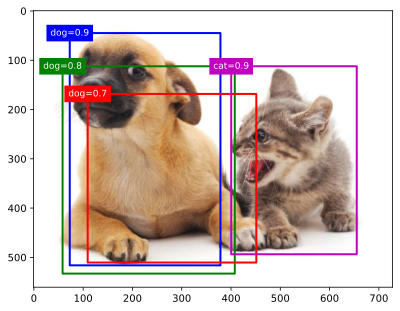

In [44]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [32]:
cls_prob = torch.tensor([[0.00, 0.00, 0.00, 0.00],
                          [0.90, 0.80, 0.70, 0.10],
                          [0.10, 0.20, 0.30, 0.90]])

In [33]:
a,  b = torch.max(cls_prob[1:], 0)

In [34]:
a

tensor([0.90, 0.80, 0.70, 0.90])

In [35]:
b

tensor([0, 0, 0, 1])